<a href="https://colab.research.google.com/github/Aditya-Kumar344/BCS-Stack-O-Matic/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%bash
pip3 install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.4 MB/s eta 0:00:00


In [4]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.5 MB/s eta 0:00:00


In [5]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376474 sha256=ab7f070d1b7c18b1a3423167447bbccf55e110376ea723b730668fc2a05f072c
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [6]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os

In [7]:
env = gym.make("LunarLander-v3")
env = TimeLimit(env, max_episode_steps=500)

In [8]:
batch_size = 128
gamma = 0.99
epsilon_start = 0.9
epsilon_end = 0.05
epsilon_decay = 1000
learning_rate = 1e-4

In [9]:
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

In [10]:
print(f"State size: {state_size}")
print(f"Number of actions: {num_actions}")

State size: 8
Number of actions: 4


In [11]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [12]:
class Memory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def cache(self, *args):
        self.memory.append(Transition(*args))

    def recall(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [14]:
policy_net = DQN(state_size, num_actions)
target_net = DQN(state_size, num_actions)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = Memory()

In [15]:
steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], dtype=torch.long)

In [16]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.recall(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [17]:
num_episodes = 500
episode_durations = []

In [18]:
def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)

In [19]:
for i_episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.tensor([state], dtype=torch.float32)
    total_reward = 0

    for t in count():
        action = select_action(state)
        observation, reward, done, _, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], dtype=torch.float32)

        if not done:
            next_state = torch.tensor([observation], dtype=torch.float32)
        else:
            next_state = None

        memory.cache(state, action, next_state, reward)
        state = next_state

        optimize_model()
        if done:
            episode_durations.append(total_reward)
            break

    if i_episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print(f"{i_episode+1} episodes done")

print('Training Complete')


<ipython-input-19-c2545065bfab>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float32)


1 episodes done
11 episodes done
21 episodes done
31 episodes done
41 episodes done
51 episodes done
61 episodes done
71 episodes done
81 episodes done
91 episodes done
101 episodes done
111 episodes done
121 episodes done
131 episodes done
141 episodes done
151 episodes done
161 episodes done
171 episodes done
181 episodes done
191 episodes done
201 episodes done
211 episodes done
221 episodes done
231 episodes done
241 episodes done
251 episodes done
261 episodes done
271 episodes done
281 episodes done
291 episodes done
301 episodes done
311 episodes done
321 episodes done
331 episodes done
341 episodes done
351 episodes done
361 episodes done
371 episodes done
381 episodes done
391 episodes done
401 episodes done
411 episodes done
421 episodes done
431 episodes done
441 episodes done
451 episodes done
461 episodes done
471 episodes done
481 episodes done
491 episodes done
Training Complete


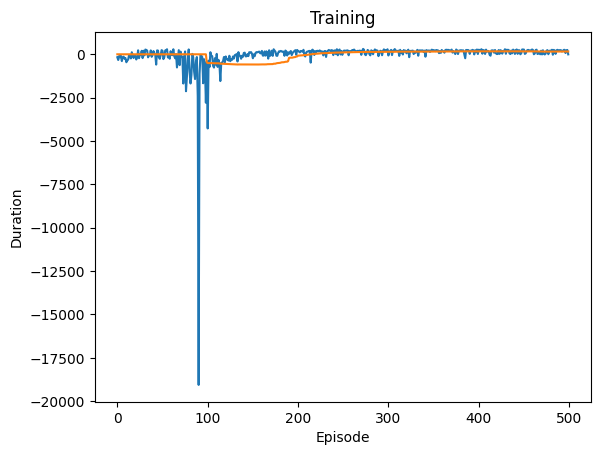

In [66]:
plot_durations()

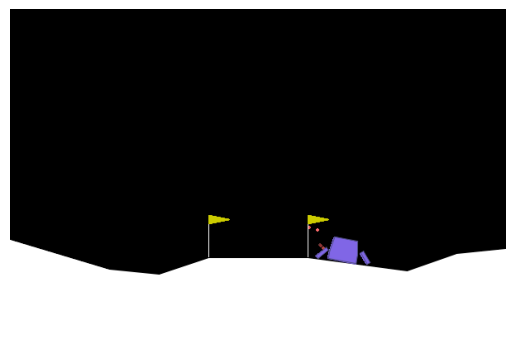

In [71]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

env = gym.make("LunarLander-v3", render_mode="rgb_array")

state, _ = env.reset()
done = False

fig, ax = plt.subplots()


img = env.render()
img = np.array(img)

img_plot = ax.imshow(img)
ax.axis('off')

display(fig)

while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, _ = env.step(action)
    img = env.render()
    img = np.array(img)

    img_plot.set_data(img)

    clear_output(wait=True)
    display(fig)

    plt.pause(0.0001)

env.close()
